In [ ]:
"""
This IPython Notebook implements a portfolio optimization tool based on Modern
Portfolio Theory, developed by Harry Markowitz. Historical stock data from 
S&P 500, Nasdaq Composite, and Dow Jones Industrial Average (DJIA) are used 
to calculate the optimal portfolio weights that minimize portfolio risk for 
a given expected return.

User provides the stock tickers they're interested in, along with minimum 
weight they desire to allocate to each stock in their portfolio. Script then
determines the range of possible returns given the minimum weights and prompts
the user to specify desired expected return.

The script then uses mathematical optimization to determine the optimal 
portfolio composition that achieves the user's desired return while minimizing 
portfolio risk. This is done with constraints that weights of all stocks in 
portfolio add up to 1 and no individual weight is below user-defined minimum.

Historical stock data is fetched from yahoo_fin library and optimization 
is achieved through the scipy library. 

How to use: 
1. Run the script in Python
2. When prompted, enter tickers of stock you're interested in 
3. When prompted, enter minimum weight for each stock (each between 0 and 1,
   and their sum totalling up to less than 1) 
4. When prompted, enter desired expected return (between calculated min and 
   max possible returns)
5. Script will then print out optimal weights for portfolio, along with 
   portfolio's expected return and associated standard deviation 
   
This script assumes the user has an understanding of financial markets and 
Modern Portfolio Theory. This script should not be used as a financial advice.
"""

In [2]:
# Install if necessary 

# pip install yahoo_fin
# pip install yahoo_fin --upgrade
# pip install requests_html

In [30]:
import warnings
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import pickle
from scipy.optimize import minimize
from scipy.optimize import Bounds
import yahoo_fin.stock_info as si
from yahoo_fin.stock_info import get_data
import multiprocessing as mp
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [4]:
# List of tickers for S&P 500, Nasdaq Composite and DJIA 
sp500_list = si.tickers_sp500() 
print(f"Number of stocks in S&P 500: {len(sp500_list)}")

nasdaq_list = si.tickers_nasdaq() 
print(f"Number of stocks in Nasdaq Composite: {len(nasdaq_list)}")

dow_list = si.tickers_dow() 
print(f"Number of stocks in DJIA: {len(dow_list)}")

Number of stocks in S&P 500: 503
Number of stocks in Nasdaq Composite: 5259
Number of stocks in DJIA: 30


In [5]:
# Combine information on all stock tickers from S&P 500, Nasdaq Composite and 
# DJIA into one combined list 
combined_list = list(set(sp500_list + nasdaq_list + dow_list))

In [ ]:
# This code takes around 30 minutes for all stock tickers from 
# S&P 500, Nasdaq Composite and DJIA 

# Date today, format it as "dd/mm/yyyy"
date_today = date.today().strftime("%d/%m/%Y")

# Date 10 years ago 
date_today_split = date_today.split("/") 
date_today_split[2] = str(int(date_today_split[2])-10)
date_start = "/".join(date_today_split) 

# Dictionary to store historical date per ticker 
h_data = {} 

for ticker in combined_list: 
    try: 
        temp_data = get_data(ticker, start_date=date_start, end_date=
                             date_today,index_as_date=False, interval="1wk") 
        if not (temp_data['date'].iloc[-1] == temp_data['date'].iloc[0]): 
            h_data[ticker] = temp_data 
    except Exception as e: 
        print(f"Could not fetch data for {ticker}, Error {e}")

In [12]:
# Save h_data to a pickle file
# with open('C:\\Users\\sjpar\\Desktop\\iCloudDrive\\DataProject2\\h_data.pkl',
#           'wb') as f:
#       if h_data: 
#           pickle.dump(h_data, f)

In [ ]:
# Open saved h_data 
with open('C:\\Users\\sjpar\\Desktop\\iCloudDrive\\DataProject2\\h_data.pkl',
          'rb') as f:
    h_data = pickle.load(f)

In [13]:
# Initialize dictionary to store return & risk data for each ticker 
return_risk_data = {} 

# Initialize dataframe to store return data for each ticker
return_df = pd.DataFrame() 

for ticker in h_data: 
    # Calculate annual return 
    time_difference = relativedelta(h_data[ticker]['date'].iloc[-1],
                                    h_data[ticker]['date'].iloc[0])
    duration = round(time_difference.years + time_difference.months/12 + 
                     time_difference.days/365, 3)
    annual_return = (h_data[ticker]['adjclose'].iloc[-1] /
                     h_data[ticker]['adjclose'].iloc[0]) ** (1/duration) - 1 
    
    # Calculate annual risk 
    returns = h_data[ticker]['adjclose'].pct_change().dropna() 
    risk = returns.std() 
    annual_risk = risk * np.sqrt(52) 
    
    return_df[ticker] = returns 
    
    return_risk_data[ticker] = (annual_return, annual_risk)

# Calculate covariance matrix 
cov_matrix = return_df.cov() 

In [77]:
user_input = input("Tickers of the stocks (separated by space): ")
tickers = list(set(user_input.split()))

# Check that user input contains valid tickers 
valid_tickers = [ticker for ticker in tickers if ticker in return_risk_data]
if len(valid_tickers) < len(tickers): 
    diff = len(tickers) - len(valid_tickers)
    print(f"Warning: {diff} tickers not found in data and have been ignored",
          end="\n\n")
    
# Return and risk data for valid tickers 
return_data = [return_risk_data[ticker][0] for ticker in valid_tickers]
risk_data = [return_risk_data[ticker][1] for ticker in valid_tickers]

# Covariance matrix for valid tickers only 
cov_matrix_input = return_df[valid_tickers].cov() 

# Ask user for minimum weights
min_weights = {}
for ticker in valid_tickers:
    min_weight = float(input(f"Enter minimum weight for {ticker} (0 - 1): "))
    min_weights[ticker] = min_weight
assert sum(min_weights.values()) <= 1, "Sum of minimum weight greater than 1"

# Find range of possible return considering the minimum weights 
min_return = sum([min_weights[ticker] * return_risk_data[ticker][0] for
                  ticker in valid_tickers]) + min(return_data) *\
                      (1-sum(min_weights.values())) 
max_return = sum([min_weights[ticker] * return_risk_data[ticker][0] for
                  ticker in valid_tickers]) + max(return_data) *\
                      (1-sum(min_weights.values()))

# Ask user for desired return
user_return = float(input(f"Enter desired expected return \
    (between {min_return:.4f} and {max_return:.4f}): "))
assert min_return <= user_return <= max_return, "User return is out of range"

# Define the objective function
def objective(weights):
    return np.dot(weights.T, np.dot(cov_matrix_input, weights))

# Initial guess for weights of portfolio: weight for each ticker set to 
# minimum weight (min_weights[ticker]) and remaining weight distributed 
# equally among rest of tickers 
weights_guess = [min_weights[ticker] + (1 - sum(min_weights.values())) /
                 len(valid_tickers) for ticker in valid_tickers]

# Lower bound for weights set to minimum weight (min_weights[ticker]) 
# Upper bound is set to 1.0  
bounds = Bounds([min_weights[ticker] for ticker in valid_tickers],
                [1.0]*len(valid_tickers))

# Define constraints:
# 1. Weights sum up to 1 
# 2. Portfolio return equal to user's desired return 
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, 
               {'type': 'eq', 'fun': lambda x: 
                   np.dot(x, return_data) - user_return}] 

# Solve the optimization problem
optimal_portfolio = minimize(fun=objective, x0=weights_guess, method='SLSQP',
                             bounds=bounds, constraints=constraints)

# Make sure that the optimization was successful 
if not optimal_portfolio.success: 
    print("Optimization not successful. Try again.")
    print("Exit message: ", optimal_portfolio.message) 
    exit(1) 

# Calculate portfolio return and standard deviation 
portfolio_return = np.dot(optimal_portfolio.x, return_data)
portfolio_variance = np.dot(optimal_portfolio.x.T, np.dot(cov_matrix_input,
                                                          optimal_portfolio.x))
portfolio_std_dev = np.sqrt(portfolio_variance)

print("Optimal portfolio weights:") 
for i in range(len(valid_tickers)): 
    print(f"{valid_tickers[i]:<5}: {optimal_portfolio.x[i] * 100:.2f}%")
print() 

print(f"Portfolio return: {portfolio_return * 100:.4f}%")
print(f"Portfolio standard deviation: {portfolio_std_dev * 100:.4f}%")

Optimal portfolio weights:
AMZN : 17.99%
TSLA : 3.27%
MSFT : 24.26%
META : 16.32%
NVDA : 38.16%

Portfolio return: 40.0000%
Portfolio standard deviation: 3.0152%


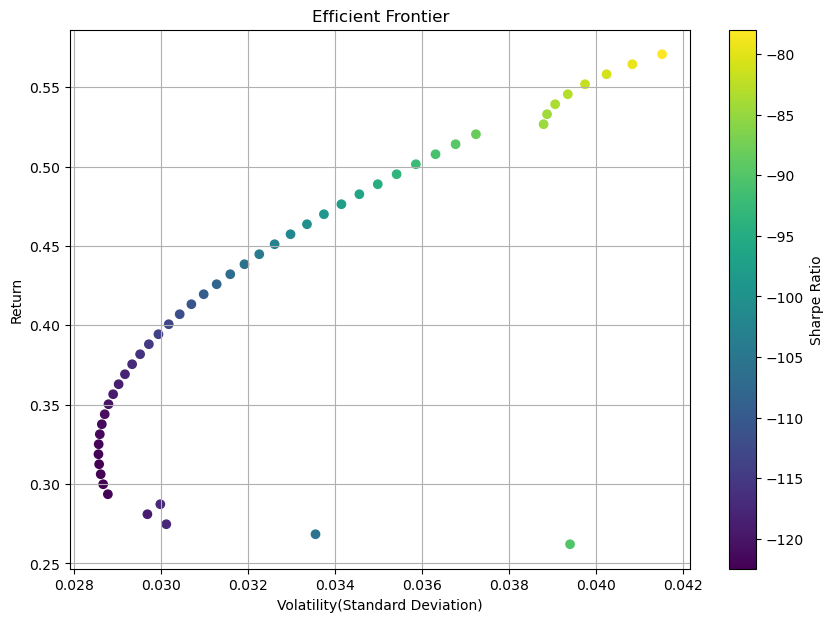

In [78]:
# Get risk free rate derived from Treasury Yield 10 Years (^TNX) 
risk_free_rate = get_data("^TNX")['adjclose'].dropna()[-1]

# Efficient frontier
target_returns = np.linspace(min_return, max_return, 50)
portfolio_std_devs = []

for target_return in target_returns:
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: 
                       np.dot(x, return_data) - target_return}]
    
    optimal_portfolio = minimize(fun=objective, x0=weights_guess,
                                 method='SLSQP', bounds=bounds,
                                 constraints=constraints)
    
    portfolio_variance = np.dot(optimal_portfolio.x.T, 
                                np.dot(cov_matrix_input, optimal_portfolio.x))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    
    portfolio_std_devs.append(portfolio_std_dev)

# Plotting the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(portfolio_std_devs, target_returns, c=(
    target_returns-risk_free_rate) / portfolio_std_devs, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility(Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()